# All Libraries

In [ ]:
import pickle
import numpy
import tensorflow
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau , EarlyStopping
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

# Google drive mount

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

In [ ]:
X_train=pd.read_csv('/content/gdrive/MyDrive/NTI/Automated Video Surveillance/face_verification/dataframes/train.csv')
X_test=pd.read_csv('/content/gdrive/MyDrive/NTI/Automated Video Surveillance/face_verification/dataframes/test.csv')
X_val=pd.read_csv('/content/gdrive/MyDrive/NTI/Automated Video Surveillance/face_verification/dataframes/val.csv')

# Building Model

In [ ]:
def building_model():
  def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')
    # Siamese L1 Distance class
  def L1Dist(input_embedding,validation_embedding):

      # Magic happens here - similarity calculation
    return tf.math.abs(input_embedding - validation_embedding)

  def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    embedding = make_embedding()
    # Combine siamese distance components
 
    distances = L1Dist(embedding(input_image), embedding(validation_image))
    
    # Classification layer
    classifier = Dense(3, activation='softmax')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
  siamese_model = make_siamese_model()
  tf.keras.utils.plot_model(siamese_model, to_file='model.png', show_shapes=True, show_layer_names=True)
  return siamese_model


In [ ]:
our_model = building_model()
our_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
def train_model(model,train_data,val_data,Nclasses, SHAPE , dataGenerator , EPOCHS , BATCH_SIZE,best_model):

  # call generator 
  # train and val generaator
  train_siamese_generator = dataGenerator(data = train_data,n_classes=Nclasses,batch_size=BATCH_SIZE,shape=SHAPE) 
  val_siamese_generator = dataGenerator(data =val_data,n_classes=Nclasses,batch_size=BATCH_SIZE,shape=SHAPE) 
  #def __init__(self, data, n_classes, batch_size=32, shape=(100, 100, 3), shuffle=True):

  # compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

  # define callbacks lists
  model_checkpoint_callback = ModelCheckpoint(
      filepath=best_model,
      monitor='loss', 
      verbose=0, 
      save_best_only=True, 
      mode='min')
  learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                              patience=3, 
                                              verbose=1, 
                                              factor=0.5, 
                                              min_lr=0.00001)
  es = EarlyStopping(monitor="loss", mode="min", verbose=1, patience=10)
  callbacks_list = [model_checkpoint_callback, learning_rate_reduction,es]

  # fit the model
  history = model.fit_generator(generator=train_siamese_generator,
                      validation_data=val_siamese_generator,
                      epochs=EPOCHS,callbacks=callbacks_list, verbose=2)
  return history

In [ ]:
# load generator
import sys
#sys.path.append('/content/drive/MyDrive')


sys.path.append('/content/gdrive/MyDrive/NTI/Automated Video Surveillance/face_verification')

In [ ]:
# import our Generator
from Siamese_Generator import SiameseGenerator

In [ ]:
our_model

# Training Model

In [ ]:
history = train_model(model=our_model, train_data=X_train, val_data=X_val, Nclasses=3, SHAPE=(100,100,3), dataGenerator=SiameseGenerator, EPOCHS=100, BATCH_SIZE=32, best_model='/content/gdrive/MyDrive/NTI/Automated Video Surveillance/face_verification/best.h5')

Epoch 1/100
40/40 - 1048s - loss: 0.6639 - accuracy: 0.5289 - val_loss: 0.5317 - val_accuracy: 0.6781 - lr: 0.0010 - 1048s/epoch - 26s/step
Epoch 2/100
40/40 - 27s - loss: 0.5615 - accuracy: 0.6984 - val_loss: 0.5141 - val_accuracy: 0.7125 - lr: 0.0010 - 27s/epoch - 670ms/step
Epoch 3/100
40/40 - 23s - loss: 0.5787 - accuracy: 0.7570 - val_loss: 0.5270 - val_accuracy: 0.7719 - lr: 0.0010 - 23s/epoch - 585ms/step
Epoch 4/100
40/40 - 27s - loss: 0.5387 - accuracy: 0.7812 - val_loss: 0.5208 - val_accuracy: 0.7906 - lr: 0.0010 - 27s/epoch - 672ms/step
Epoch 5/100
40/40 - 29s - loss: 0.5208 - accuracy: 0.7648 - val_loss: 0.5075 - val_accuracy: 0.8938 - lr: 0.0010 - 29s/epoch - 720ms/step
Epoch 6/100
40/40 - 24s - loss: 0.5268 - accuracy: 0.7930 - val_loss: 0.5079 - val_accuracy: 0.7312 - lr: 0.0010 - 24s/epoch - 596ms/step
Epoch 7/100
40/40 - 26s - loss: 0.5102 - accuracy: 0.7508 - val_loss: 0.4920 - val_accuracy: 0.8188 - lr: 0.0010 - 26s/epoch - 649ms/step
Epoch 8/100
40/40 - 27s - loss: 

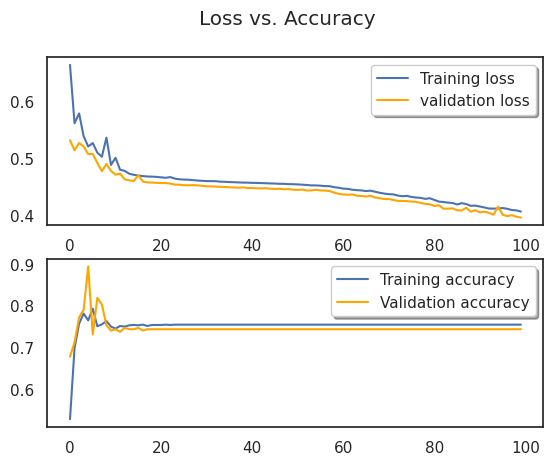

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
fig.suptitle("Loss vs. Accuracy")
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='orange', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='orange',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Evaluate Model

In [ ]:
X_test

In [ ]:
from keras.models import load_model
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.metrics import binary_accuracy
import numpy as np

# Load the saved model
model = load_model('/content/drive/MyDrive/NTI/Automated Video Surveillance/face_verification/best.h5')

# Load the test set data and labels
x_test = np.load('path/to/x_test.npy')
y_test = np.load('path/to/y_test.npy')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Compute performance metrics
threshold = 0.5  # threshold for binary classification
y_pred_classes = np.where(y_pred > threshold, 1, 0)  # convert probabilities to binary classes
tp = np.sum(np.logical_and(y_pred_classes == 1, y_test == 1))
tn = np.sum(np.logical_and(y_pred_classes == 0, y_test == 0))
fp = np.sum(np.logical_and(y_pred_classes == 1, y_test == 0))
fn = np.sum(np.logical_and(y_pred_classes == 0, y_test == 1))
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)

# Print the model's performance measures
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)